In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
n = 500 #p
T = 1 #interval between measurements
Vc0 = np.array([10, 10])
Xc0 = np.array([1000, 1000])
sigma_a2 = 0.3 **2

sigma_etD2 = 50**2
sigma_etb2 = 0.004**2   

In [3]:
Xc = np.zeros((2,n))
Vc = np.zeros((2,n))
a1 = np.zeros((n))
a2 = np.zeros((n))

a1[:] = np.random.normal(0, np.sqrt(sigma_a2), n)
a2[:] = np.random.normal(0, np.sqrt(sigma_a2), n)
Xc[:, 0] = Xc0
Vc[:, 0] = Vc0
       
for i in range(1,n):
    Vc[0, i] = Vc[0, i-1] + a1[i-1]*T
    Xc[0, i] = Xc[0, i-1] + Vc[0, i-1]*T + (a1[i-1]*T*T)/2
    Vc[1, i] = Vc[1, i-1] + a2[i-1]*T
    Xc[1, i] = Xc[1, i-1] + Vc[1, i-1]*T + (a2[i-1]*T*T)/2

In [4]:
Xtrue = np.zeros((2,n))
Xtrue[0,:] = np.sqrt(Xc[0,:]**2 + Xc[1,:]**2) #D
Xtrue[1,:] = np.arctan(Xc[0,:]/Xc[1,:]) #bet

In [5]:
Zmes = np.zeros((2,n))
Zmes[0,:] = Xtrue[0,:] + np.random.normal(0, np.sqrt(sigma_etD2), n) #D
Zmes[1,:] = Xtrue[1,:] + np.random.normal(0, np.sqrt(sigma_etb2), n) #bet

In [6]:
X0 = np.array([Zmes[0, 0]*np.sin(Zmes[1, 0]), 0, Zmes[0, 0]*np.cos(Zmes[1, 0]), 0])
P0 = np.eye(4)*(10**10)

phi = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
G = np.array([[T*T/2, 0], [T, 0], [0, T*T/2], [0, T]])
Q = G.dot(G.T) * sigma_a2

R = np.array([[sigma_etD2, 0], [0, sigma_etb2]])

In [7]:
def Kalman(n, P0, X0, phi, R, Q, Zmes):
    P_pred = np.zeros((4,4,n))
    X_pred = np.zeros((4,n))
    P_filt = np.zeros((4,4,n))
    X_filt = np.zeros((4,n))
    dh = np.zeros((2,4,n))
    K = np.zeros((4,2,n))

        # Initial P for filtering
    P_filt[:,:,0] = P0

        # Initial X_filt for filtering
    X_filt[:,0] = X0

        # Kalman filtering
    for i in range(1,n):
        P_pred[:,:,i] = (phi.dot(P_filt[:,:,i-1])).dot(phi.T) + Q

        X_pred[:,i] = phi.dot(X_filt[:,i-1].reshape(4,1)).reshape(4)
        
        dh[:,:,i] = np.array([[X_pred[0,i]/np.sqrt(X_pred[0,i]**2 + X_pred[2,i]**2), 0, X_pred[2,i]/np.sqrt(X_pred[0,i]**2 + X_pred[2,i]**2), 0], [X_pred[2,i]/(X_pred[0,i]**2 + X_pred[2,i]**2), 0, -X_pred[0,i]/(X_pred[0,i]**2 + X_pred[2,i]**2), 0]])              

        K[:,:,i] = ((P_pred[:,:,i].dot(dh[:,:,i].T)).dot(inv((dh[:,:,i].dot(P_pred[:,:,i])).dot(dh[:,:,i].T) + R)))
        D = np.sqrt(X_pred[0,i]**2 + X_pred[2,i]**2)
        bet = np.arctan(X_pred[0,i]/X_pred[2,i])
        h = np.array([D, bet])

        X_filt[:,i] = (X_pred[:,i].reshape(4,1) + K[:,:,i].dot(Zmes[:,i].reshape(2,1) - h.reshape(2,1))).reshape(4)
        P_filt[:,:,i] = P_pred[:,:,i] - (K[:,:,i].dot(dh[:,:,i])).dot(P_pred[:,:,i])

    K = np.delete(K, 0, axis = 2)
        
    X_est = np.zeros((4,n))
    X_est[0,:] = np.sqrt(X_filt[0,:]**2 + X_filt[2,:]**2)
    X_est[1,:] = np.arctan(X_filt[0,:]/X_filt[2,:])
    X_est[2,:] = np.sqrt(X_pred[0,:]**2 + X_pred[2,:]**2)
    X_est[3,:] = np.arctan(X_pred[0,:]/X_pred[2,:])
        
    return(X_est,X_filt, K)

<ipython-input-7-30b794072b0a>:37: RuntimeWarning: invalid value encountered in true_divide
  X_est[3,:] = np.arctan(X_pred[0,:]/X_pred[2,:])


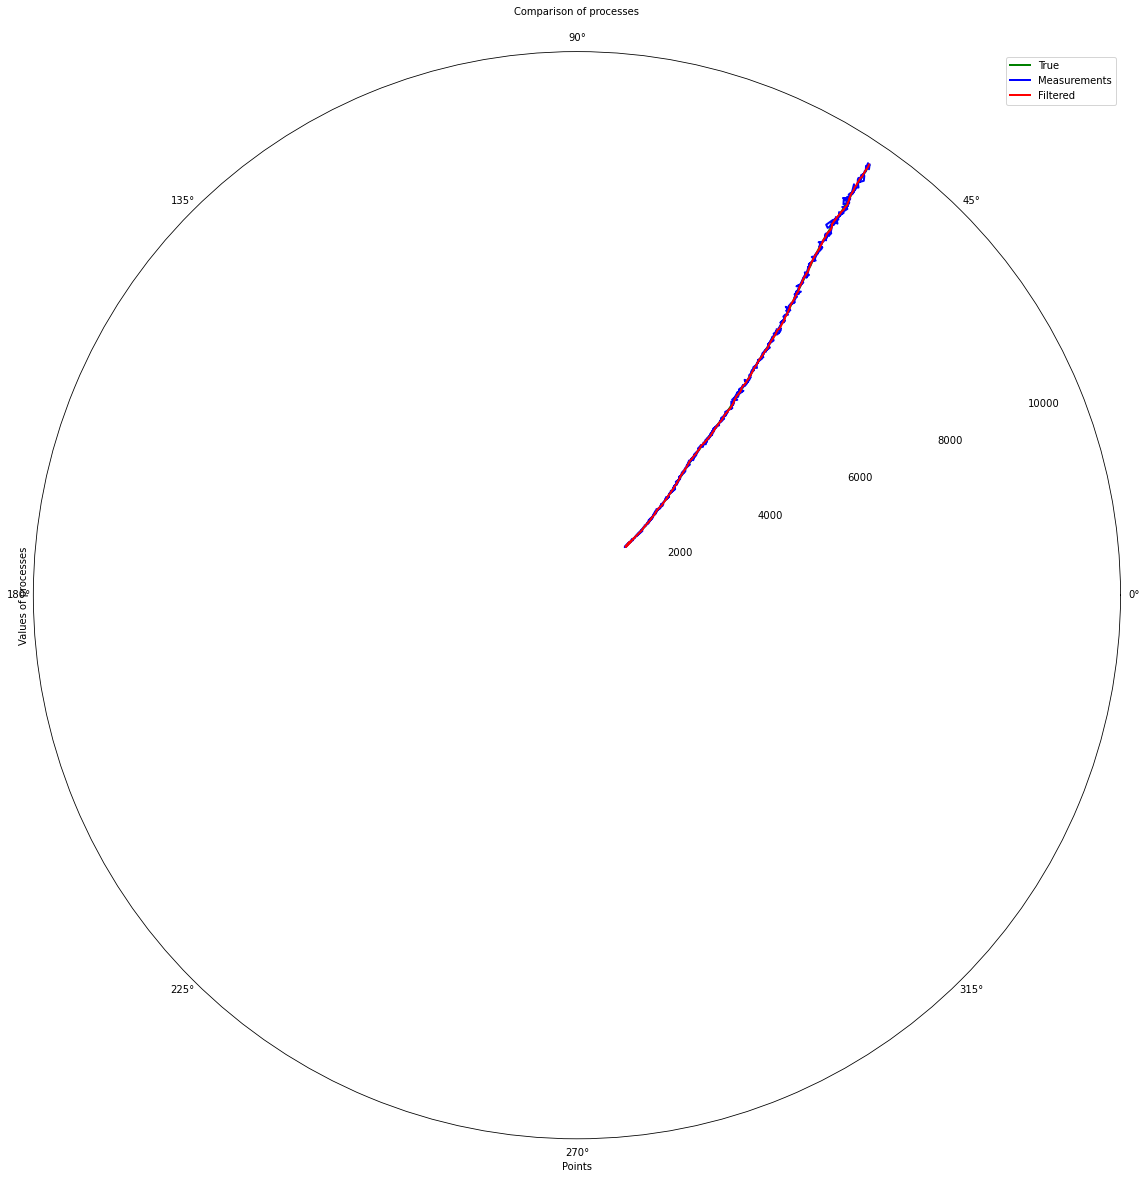

In [14]:
Kal = Kalman(n, P0, X0, phi, R, Q, Zmes)

plt.polar(Xtrue[1,:],Xtrue[0,:], linewidth = 2, label = "True", color = "g")
plt.polar(Zmes[1,:],Zmes[0,:], linewidth = 2, label = "Measurements", color = "b")
plt.polar(Kal[0][1,:],Kal[0][0,:], linewidth = 2, label = "Filtered", color = "r")
    
    
plt.legend(fontsize = 10)
plt.rcParams["figure.figsize"] = (20,20)
plt.tick_params(labelsize = 10)
plt.grid()
plt.xlabel("Points", fontsize = 10)
plt.ylabel("Values of processes", fontsize = 10)
plt.title("Comparison of processes\n", fontsize = 10)
plt.show()

In [9]:
n = 500
T = 1
M = 500

Error_filt_D = np.zeros((2, n, M))
Error_filt_Bet = np.zeros((2, n, M))
Error_pred_D = np.zeros((2, n, M))
Error_pred_Bet = np.zeros((2, n, M))

for k in range(M):
    Vc0 = np.array([10, 10])
    Xc0 = np.array([1000, 1000])
    sigma_a2 = 0.3 **2

    sigma_etD2 = 50**2
    sigma_etb2 = 0.004**2     

    Xc = np.zeros((2,n))
    Vc = np.zeros((2,n))
    a = np.zeros((2,n))

    a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), n)
    Xc[:, 0] = Xc0
    Vc[:, 0] = Vc0

    for i in range(1,n):
        Vc[:, i] = Vc[:, i-1] + a[:, i-1]*T
        Xc[:, i] = Xc[:, i-1] + Vc[:, i-1]*T + (a[:, i-1]*T*T)/2
        
    Xtrue = np.zeros((2,n))
    Xtrue[0,:] = np.sqrt(Xc[0,:]**2 + Xc[1,:]**2) #D
    Xtrue[1,:] = np.arctan(Xc[0,:]/Xc[1,:]) #bet

    Zmes = np.zeros((2,n))
    Zmes[0,:] = Xtrue[0,:] + np.random.normal(0, np.sqrt(sigma_etD2), n) #D
    Zmes[1,:] = Xtrue[1,:] + np.random.normal(0, np.sqrt(sigma_etb2), n) #bet
    
    X0 = np.array([Zmes[0, 0]*np.sin(Zmes[1, 0]), 0, Zmes[0, 0]*np.cos(Zmes[1, 0]), 0])
    P0 = np.eye(4)*(10**10)

    phi = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
    G = np.array([[T*T/2, 0], [T, 0], [0, T*T/2], [0, T]])
    Q = G.dot(G.T) * sigma_a2

    R = np.array([[sigma_etD2, 0], [0, sigma_etb2]])

    X_est = Kalman(n, P0, X0, phi, R, Q, Zmes)[0]
    
    Error_filt_D[:, :, k] = (Xtrue[0, :] - X_est[0, :]) ** 2
    Error_pred_D[:, :, k] = (Xtrue[0, :] - X_est[2, :]) ** 2
    Error_filt_Bet[:, :, k] = (Xtrue[1, :] - X_est[1, :]) ** 2
    Error_pred_Bet[:, :, k] = (Xtrue[1, :] - X_est[3, :]) ** 2

<ipython-input-7-30b794072b0a>:37: RuntimeWarning: invalid value encountered in true_divide
  X_est[3,:] = np.arctan(X_pred[0,:]/X_pred[2,:])


In [10]:
Final_err_filt_D = np.sqrt(np.sum(Error_filt_D, axis = 2) / (M - 1))
Final_err_pred_D = np.sqrt(np.sum(Error_pred_D, axis = 2) / (M - 1))
Final_err_filt_Bet = np.sqrt(np.sum(Error_filt_Bet, axis = 2) / (M - 1))
Final_err_pred_Bet = np.sqrt(np.sum(Error_pred_Bet, axis = 2) / (M - 1))

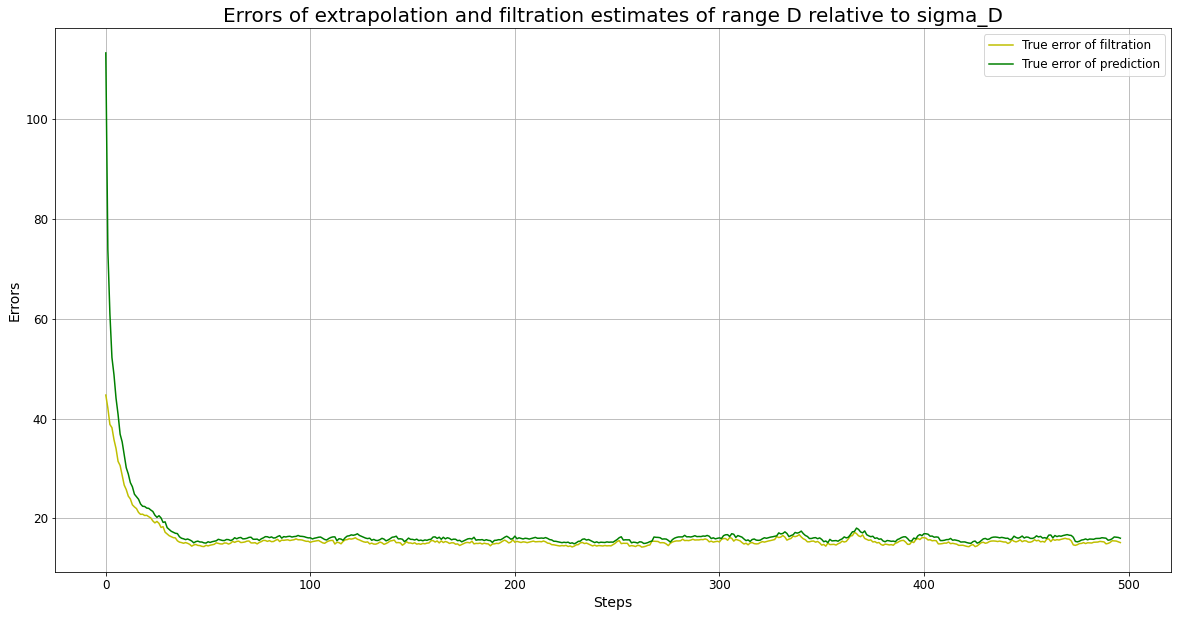

In [11]:
fig, f = plt.subplots(figsize=(20,10))
f.set_title("Errors of extrapolation and filtration estimates of range D relative to sigma_D", fontsize = 20)
f.set_xlabel("Steps", fontsize = 14)
f.set_ylabel("Errors", fontsize = 14)
f.plot(Final_err_filt_D[0, 3:], label = "True error of filtration", color = "y")
f.plot(Final_err_pred_D[0, 3:], label = "True error of prediction", color = "g")
f.tick_params(labelsize = 12)
f.legend(fontsize = 12)
f.grid()

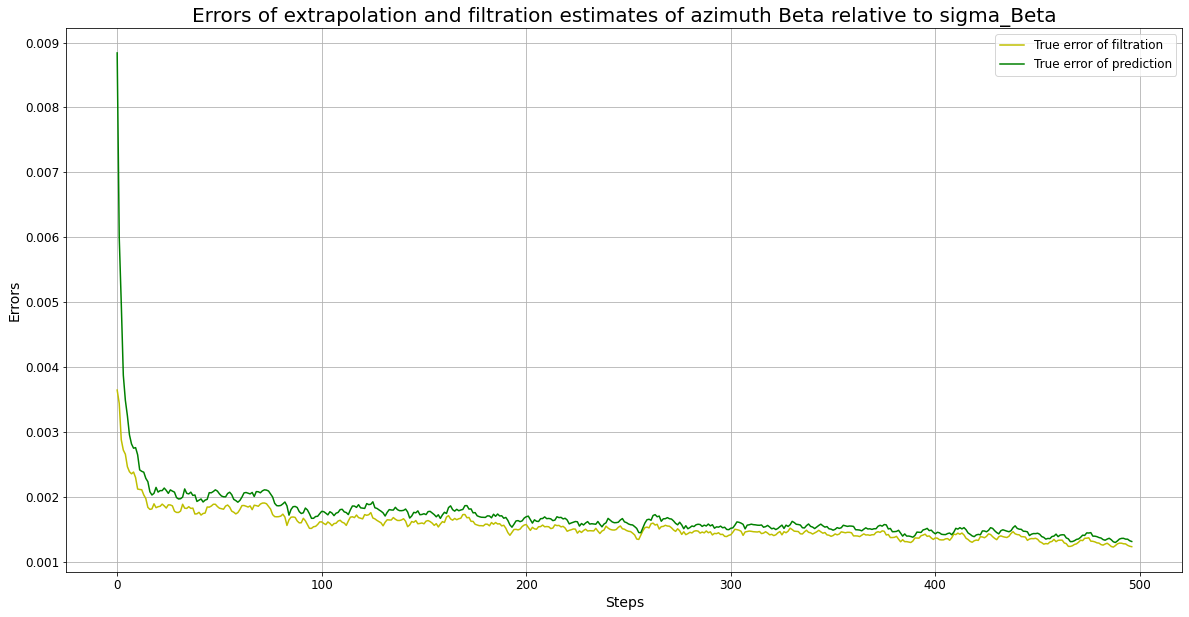

In [12]:
fig, f = plt.subplots(figsize=(20,10))
f.set_title("Errors of extrapolation and filtration estimates of azimuth Beta relative to sigma_Beta", fontsize = 20)
f.set_xlabel("Steps", fontsize = 14)
f.set_ylabel("Errors", fontsize = 14)
f.plot(Final_err_filt_Bet[0, 3:], label = "True error of filtration", color = "y")
f.plot(Final_err_pred_Bet[0, 3:], label = "True error of prediction", color = "g")
f.tick_params(labelsize = 12)
f.legend(fontsize = 12)
f.grid()

<ipython-input-7-30b794072b0a>:37: RuntimeWarning: invalid value encountered in true_divide
  X_est[3,:] = np.arctan(X_pred[0,:]/X_pred[2,:])


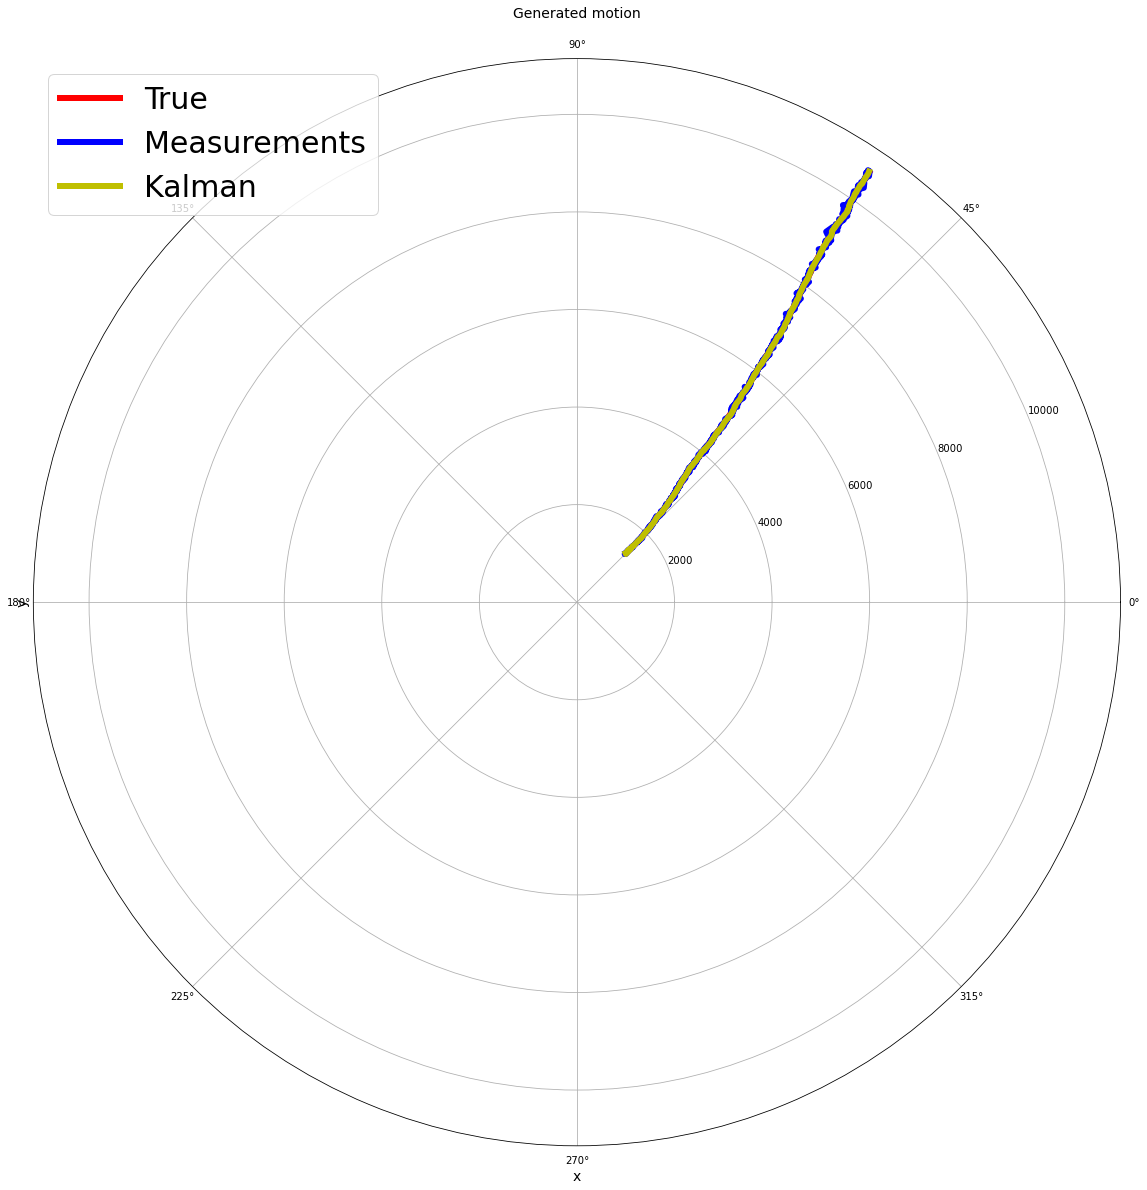

In [13]:
plt.polar(Xtrue[1,1:],Xtrue[0,1:], linewidth = 6, label = "True", color = "r")
plt.polar(Zmes[1,1:],Zmes[0,1:], linewidth = 6, label = "Measurements", color = "b")
plt.polar(Kalman(n, P0, X0, phi, R, Q, Zmes)[0][1,1:],Kalman(n, P0, X0, phi, R, Q, Zmes)[0][0,1:], linewidth = 6, label = "Kalman", color = "y")

plt.legend(fontsize = 30)
plt.rcParams["figure.figsize"] = (20, 20)
plt.tick_params(labelsize = 10)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.title("Generated motion\n", fontsize = 14)
plt.show()